In [1]:
% matplotlib inline
import bayleaf as bf
import numpy as np
import pymc3 as pm
import matplotlib.pylab as plt
import theano
import theano.tensor as tt

/anaconda/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import pandas as pd
FLOAT_EPS = np.finfo(float).eps
np.random.seed(34333823)
n = 65000
## generate gamma frailty according to parameters \theta^{-1}
theta = .510
## generate gamma frailty term, ~Γ(θ^{-1},θ), np parameterizes with scale, so
### In later versions of this, we merge this within the data generator
## functionalize this
β1 = np.array([0.63, 0.03])
β2 = np.array([0.8, 0.03])
β3 = np.array([0.9, 0.03])
βs = np.vstack([β1,β2,β3])
k=3
λk = np.array([0.0047, 0.0037, 0.0057])
ρk = np.array([0.716, .725, .73])

r_true = .5
r_this = .5
def sim_simple_covs(n):
    sex = np.random.binomial(n=1,p=.5,size =n)
    age = np.random.gamma(size=n,  shape = 10, scale = 1/.3)
    return(np.array([sex,age]).T)
X = sim_simple_covs(n)
# Simulate Survival Times, generalize for k categories
def sim_weibull_frail_generalized(betas, theta, X, lam, r, rho, maxtime, cens_end, n, k, first = False):
    '''
    Function to simulate transformed weibull survival times with uniform censoring according to the weibull PH model
    Parameters
    ----------
    betas : effect sizes
    lam : scale parameters for different levels (must be dimension kx1)
    theta : parameter of gamma distribution of frailties
    rho : shape parameters for each level (kx1)
    X : covariates
    maxtime : maximum study time
    r : transformation parameter
    k : number of outcomes
    first : boolean, do we want to return just the time to first event
    '''
    w = np.random.gamma(size = n, shape=theta**(-1), scale = theta)
    ## from probability integral transform
    Te = ((np.exp(-(np.log(np.random.uniform(size=(n,k)))*r)/w[:,None])-1)/(r*lam*np.exp(np.dot(X,betas.T))))**(1/rho)
    # Do we want time to first event r?
    # generate censoring time, unif and truncated by tau
    if first == True:
        Cens = 1+cens_end*np.random.uniform(size = n)
        Cens[Cens>maxtime] = maxtime
        alltimes = np.vstack((Cens,Te.T)).T
        eventType = []
        for i in range(len(w)):
            eventType.append(np.where(alltimes[i,]==np.amin(alltimes[i,]))[0][0])
        obs_t = list(np.amin(alltimes,axis = 1))
        out = pd.DataFrame(np.array([obs_t, eventType, pd.Series(X[:,[0]][:,0]),pd.Series(X[:,[1]][:,0]),w])).T
        # Clean up for the covariates
        out.columns = ["obs_t", "eventType", "sex", "age", "sim_frail"]
    else:
        Cens = 1+cens_end*np.random.uniform(size = (n,k))
        Cens[Cens>maxtime] = maxtime
        results = np.repeat(0, n)
        names_df = ["del"]
        # loop over levels
        for level in range(k):
            obs_t = np.amin(np.array([Te[:,level], Cens[:,level]]).T, axis =1) # observed time
            names_df = np.append(names_df, "time_"+str(level+1))
            delta = (Te[:,level] < Cens[:,level]) + 0 # censoring indicator
            names_df = np.append(names_df, "delta_"+str(level+1))
            results = np.vstack((results, obs_t))
            results = pd.DataFrame(np.vstack((results, delta)))
        # Names of X
        x_names = ["X_"+str(j+1) for j in np.arange(X.shape[1])]
        names_df = np.append(names_df, x_names)
        names_df = np.append(names_df, "frailty") # now add frailty
        out = pd.DataFrame(np.vstack((results, X.T, w.T)).T)
        out.columns = names_df
        out = out.iloc[:, out.columns!="del"] # get rid of extra column
    return(out)
## NOW ACTUALLY GENERATE THE DATA, this is the intitialization step
X = sim_simple_covs(n)
data = sim_weibull_frail_generalized(betas=βs,
                              theta = theta,
                              X = X,
                              lam = λk,
                              rho = ρk,
                              maxtime=200,
                              cens_end = 300,
                              r = r_true ,k=3, first=False, n=n)

In [3]:
data.head(10)

,time_1,delta_1,time_2,delta_2,time_3,delta_3,X_1,X_2,frailty
0,134.756939,1.0,58.432164,1.0,49.614960,0.0,1.0,31.819014,0.729976
1,32.784499,0.0,195.742523,0.0,45.805219,1.0,0.0,45.665823,0.517624
2,73.537195,0.0,9.798205,0.0,5.972532,1.0,0.0,42.286111,1.675335
3,200.000000,0.0,158.857723,0.0,135.403735,0.0,0.0,21.494183,0.916369
4,81.772050,0.0,27.412719,1.0,68.090550,1.0,1.0,40.687292,0.272626
5,200.000000,0.0,51.202725,1.0,200.000000,0.0,0.0,30.666874,0.228618
6,46.798055,0.0,21.836535,0.0,200.000000,0.0,1.0,19.744297,0.118339
7,7.733794,1.0,8.838422,1.0,19.753714,1.0,0.0,32.003297,1.145173
8,158.582451,0.0,200.000000,0.0,124.722063,1.0,1.0,21.724243,0.407463
9,45.786483,0.0,11.034827,1.0,200.000000,0.0,0.0,34.683112,0.553351


In [4]:
with pm.Model() as m1:
    bf.Frailty.from_formula('([time_1, time_2, time_3],[delta_1, delta_2, delta_3])~X_1+X_2-1', data = data)
    MAP_this = pm.find_MAP()

logp = -4.4737e+05, ||grad|| = 378.12: 100%|██████████| 515/515 [00:49<00:00, 10.50it/s] 


In [5]:
MAP_this

{'X_1_0': array(0.64311844),
 'X_1_1': array(0.80347756),
 'X_1_2': array(0.91573318),
 'X_2_0': array(0.02997284),
 'X_2_1': array(0.03073008),
 'X_2_2': array(0.03146077),
 'lam_0': array(0.00475415),
 'lam_0_log__': array(-5.34873708),
 'lam_1': array(0.00366637),
 'lam_1_log__': array(-5.60855202),
 'lam_2': array(0.00523756),
 'lam_2_log__': array(-5.25189937),
 'r_0': array(0.50356867),
 'r_0_log__': array(-0.68603519),
 'r_1': array(0.50092034),
 'r_1_log__': array(-0.69130818),
 'r_2': array(0.48964521),
 'r_2_log__': array(-0.71407421),
 'rho_0': array(0.71292791),
 'rho_0_log__': array(-0.33837497),
 'rho_1': array(0.72029065),
 'rho_1_log__': array(-0.32810046),
 'rho_2': array(0.73524957),
 'rho_2_log__': array(-0.30754529),
 'theta': array(0.50605841),
 'theta_log__': array(-0.68110319)}

In [6]:
with pm.Model() as m2:
    bf.Frailty_FixMAP.from_formula('([time_1, time_2, time_3],[delta_1, delta_2, delta_3])~X_1+X_2-1', 
                                   data = data, MAP = MAP_this)
    MAP2 = pm.find_MAP()

Formula Call: ([time_1, time_2, time_3],[delta_1, delta_2, delta_3])~X_1+X_2-1
Dimension of Outcome Variable: 3
Covariates in Model: ['X_1', 'X_2']
Percent Censored in Each Direction:
time_1: 0.6522
time_2: 0.6739846153846154
time_3: 0.5690307692307692
Minibatch Size: False
<TensorType(float64, matrix)>


logp = -4.4737e+05, ||grad|| = 1,011.3: 100%|██████████| 321/321 [00:28<00:00, 11.15it/s] 


In [ ]:
with pm.Model() as m3:
    bf.Frailty_FixMAP.from_formula('([time_1, time_2, time_3],[delta_1, delta_2, delta_3])~X_1+X_2-1', 
                                   data = data, MAP = MAP_this, minibatch =20000)    
    approx = pm.fit(50000, method = pm.FullRankADVI(), start = MAP2)


Formula Call: ([time_1, time_2, time_3],[delta_1, delta_2, delta_3])~X_1+X_2-1
Dimension of Outcome Variable: 3
Covariates in Model: ['X_1', 'X_2']
Percent Censored in Each Direction:
time_1: 0.6522
time_2: 0.6739846153846154
time_3: 0.5690307692307692
Minibatch Size: 20000
<TensorType(float64, matrix)>
We're Mini batching


Average Loss = 1.5132e+06:   1%|          | 553/50000 [00:14<21:30, 38.30it/s]

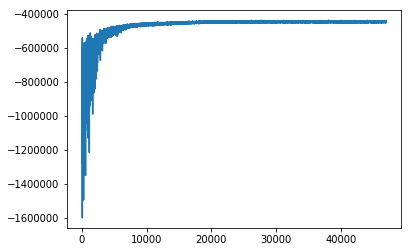

In [18]:
plt.plot(-approx.hist[3000:])

In [19]:
with m3:
    variational_trace_save = approx.sample(5000)

In [20]:
pm.summary(variational_trace_save)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
X_1_0,0.644022,0.017296,0.000234,0.609814,0.677470
X_2_0,0.030220,0.001604,0.000023,0.027185,0.033460
X_1_1,0.803943,0.020973,0.000300,0.762222,0.844233
X_2_1,0.031078,0.000619,0.000009,0.029810,0.032260
X_1_2,0.907548,0.020003,0.000265,0.865986,0.943774
X_2_2,0.030140,0.001297,0.000018,0.027595,0.032628
lam_0,0.004774,0.000184,0.000003,0.004420,0.005146
rho_0,0.715137,0.005567,0.000080,0.704731,0.726482
lam_1,0.003745,0.000169,0.000003,0.003405,0.004061
rho_1,0.719367,0.005900,0.000086,0.707983,0.730917


In [18]:
# Copula 

# Test Copula Model
# Im
## Generated Dataset
import pandas as pd
n = 5000
β1 = np.array([1.63, 0.03])
β2 = np.array([0.8, 0.03])
#β3 = np.array([0.9, 0.03])
βs = np.vstack([β1,β2])
λk = np.array([0.0047, 0.0037])
ρk = np.array([0.716, .725])
def sim_simple_covs(n):
    sex = np.random.binomial(n=1,p=.5,size =n)
    age = np.random.gamma(size=n,  shape = 10, scale = 1/.3)
    return(np.array([sex,age]).T)

X = sim_simple_covs(n)
exp_1 = np.exp(np.dot(X,βs.T))[:,0]
exp_2 = np.exp(np.dot(X,βs.T))[:,1]

α = 3.210
λ_s = λk[0]
ρ_s = ρk[0]
r_s =0.5

λ_t = λk[1]
ρ_t = ρk[1]
r_t =1.5

U_s = np.random.uniform(size=n)
S = ((U_s**(-r_s)-1)/(r_s*exp_1*λ_s))**(1/ρ_s)
U_t = np.random.uniform(size=n)
S_T = ((U_t**(-(α)/(α+1))-1)*(U_s)**(-α)+1)**(-α**(-1))
T = ((S_T**(-r_t)-1)/(r_t*exp_2*λ_t))**(1/ρ_t)

Te = np.vstack([S,T]).T
cens_end = 7500
maxtime = 500
Cens = 1+cens_end*np.random.uniform(size = (n,2))
Cens[Cens>maxtime] = maxtime

Cens = 1+cens_end*np.random.uniform(size = (n,2))
Cens[Cens>maxtime] = maxtime
results = np.repeat(0, n)
names_df = ["del"]
# loop over levels
for level in range(2):
    obs_t = np.amin(np.array([Te[:,level], Cens[:,level]]).T, axis =1) # observed time
    names_df = np.append(names_df, "time_"+str(level+1))
    delta = (Te[:,level] < Cens[:,level]) + 0 # censoring indicator
    names_df = np.append(names_df, "delta_"+str(level+1))
    results = np.vstack((results, obs_t))
    results = pd.DataFrame(np.vstack((results, delta)))
#
x_names = ["X_"+str(j+1) for j in np.arange(X.shape[1])]
names_df = np.append(names_df, x_names)
#names_df = np.append(names_df, "frailty") # now add frailty
out = pd.DataFrame(np.vstack((results, X.T)).T)
out.columns = names_df
out = out.iloc[:, out.columns!="del"]



In [19]:
with bf.pm.Model() as test_run:
    bf.Copula.from_formula(formula = "([time_1, time_2],[delta_1, delta_2])~X_1+X_2-1", data = out, family = "clayton_trans")
    MAP = bf.pm.find_MAP()


logp = -37,998, ||grad|| = 240.96: 100%|██████████| 288/288 [00:04<00:00, 65.23it/s] 


In [21]:
MAP

{'X_1_1': array(1.33391109),
 'X_1_2': array(0.77393521),
 'X_2_1': array(0.02430971),
 'X_2_2': array(0.0284506),
 'alpha': array(3.53520402),
 'alpha_log__': array(1.26277101),
 'lam_1': array(0.00884076),
 'lam_1_log__': array(-4.72838212),
 'lam_2': array(0.00388419),
 'lam_2_log__': array(-5.5508403),
 'r_1': array(0.01557235),
 'r_1_log__': array(-4.16225827),
 'r_2': array(1.37917699),
 'r_2_log__': array(0.32148693),
 'rho_1': array(0.59916356),
 'rho_1_log__': array(-0.51222066),
 'rho_2': array(0.702151),
 'rho_2_log__': array(-0.3536068)}

In [22]:
with test_run:
    trace = bf.pm.sample(2000, tune =6000, start =MAP, seed=seed)

100%|██████████| 8000/8000 [1:14:07<00:00,  1.80it/s]


In [23]:
results = round(pm.summary(trace),3)
print(results.to_latex(escape=False,column_format='cccccc',index=True,))


\begin{tabular}{cccccc}
\toprule
{} &   mean &     sd &  mc_error &  hpd_2.5 &  hpd_97.5 &     n_eff &  Rhat \\
\midrule
X_1_1 &  1.602 &  0.051 &     0.001 &    1.502 &     1.705 &  1971.755 &   1.0 \\
X_2_1 &  0.029 &  0.002 &     0.000 &    0.026 &     0.032 &  2288.539 &   1.0 \\
X_1_2 &  0.806 &  0.059 &     0.001 &    0.692 &     0.925 &  2346.669 &   1.0 \\
X_2_2 &  0.028 &  0.003 &     0.000 &    0.023 &     0.033 &  2296.181 &   1.0 \\
lam_2 &  0.004 &  0.001 &     0.000 &    0.003 &     0.005 &  1700.584 &   1.0 \\
lam_1 &  0.005 &  0.001 &     0.000 &    0.004 &     0.006 &  1735.984 &   1.0 \\
alpha &  3.399 &  0.105 &     0.002 &    3.191 &     3.604 &  3019.516 &   1.0 \\
r_1   &  0.403 &  0.057 &     0.001 &    0.294 &     0.517 &  1904.724 &   1.0 \\
rho_2 &  0.689 &  0.023 &     0.001 &    0.643 &     0.734 &  1723.674 &   1.0 \\
rho_1 &  0.692 &  0.016 &     0.000 &    0.661 &     0.723 &  1748.297 &   1.0 \\
r_2   &  1.178 &  0.177 &     0.004 &    0.842 &     1.514 